In [1]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
import rdkit
print(rdkit.__version__)

2022.09.1


Start by getting some molecules to work with

In [2]:
ms = [x for x in Chem.SmilesMolSupplier('../data/BLSets_selected_actives.txt') if x.GetProp('_Name')=='CHEMBL204']
len(ms)

452

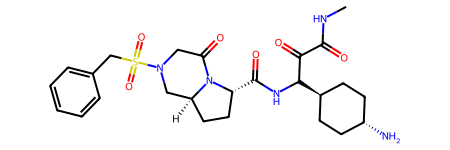

In [20]:
ms[0]

# Generators and fingerprints

The idea of the new code is that all supported fingerprinting algorithms can be used the same way: you create a generator for that fingerprint algorithm with the appropriate parameters set and then ask the generator to give you the fingerprint type you want for each molecule.

Let's look at how that works for Morgan fingerprints. When we create the generator we can optionally provide the radius and the size of the fingerprints to be generated:

In [6]:
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)

The fingerprint generator knows how to create four separate types of fingerprints:
1. `fpgen.GetFingerprint(m)`: returns a bit vector of size `fpSize`
2. `fpgen.GetCountFingerprint(m)`: returns a count vector of size `fpSize`
3. `fpgen.GetSparseFingerprint(m)`: returns a sparse bit vector
4. `fpgen.GetSparseCountFingerprint(m)`: returns a sparse count vector

The sparse bit and count vectors are of variable size, depending on the fingerprint type, but are always very large (at least $2^{32}-1$).

Here's a demonstration of that:

In [7]:
# bit vectors:
fp = mfpgen.GetFingerprint(ms[0])
sfp = mfpgen.GetSparseFingerprint(ms[0])

# count vectors:
cfp = mfpgen.GetCountFingerprint(ms[0])
scfp = mfpgen.GetSparseCountFingerprint(ms[0])

In [8]:
print(f'fp: {type(fp)} {len(fp)}')
print(f'sfp: {type(sfp)} {len(sfp)}')
print(f'cfp: {type(cfp)} {cfp.GetLength()}')
print(f'scfp: {type(scfp)} {scfp.GetLength()}')

fp: <class 'rdkit.DataStructs.cDataStructs.ExplicitBitVect'> 2048
sfp: <class 'rdkit.DataStructs.cDataStructs.SparseBitVect'> 4294967295
cfp: <class 'rdkit.DataStructs.cDataStructs.UIntSparseIntVect'> 2048
scfp: <class 'rdkit.DataStructs.cDataStructs.ULongSparseIntVect'> 18446744073709551615


# Basic usage

As of this writing (RDKit v2022.09), the fingerprinting algorithms supported by the fingerprint generators are:
1. Morgan
2. Feature Morgan (this is a variation of the Morgan fingerprint)
3. RDKit
4. Atom pairs
5. Topological torsions

I already showed how to generate Morgan fingerprints, creating generators for the other types looks the same:

In [15]:
rdkgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=2048)
apgen = rdFingerprintGenerator.GetAtomPairGenerator(fpSize=2048)
ttgen = rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=2048)

Feature Morgan fingerprints are created using a Morgan generator which uses a different method of assigning atom invariants (atom types):

In [17]:
fmgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2,
                  atomInvariantsGenerator=rdFingerprintGenerator.GetMorganFeatureAtomInvGen())

And the generators all have the same API for creating fingerprints:

In [12]:
rdkfp = rdkgen.GetFingerprint(ms[0])
apfp = apgen.GetFingerprint(ms[0])
ttfp = ttgen.GetFingerprint(ms[0])

Parameters specific to the individual fingerprint algorithms can be provided when creating the generator. We saw this above for the Morgan fingerprint, here's an example of changing the max path length used for the RDKit FP:

In [13]:
rdk5gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5,fpSize=2048)
rdk5gen.GetFingerprint(ms[0]).GetNumOnBits(),rdkgen.GetFingerprint(ms[0]).GetNumOnBits()

(339, 984)

The default RDKit FP generator, which uses a max path length of 7, sets many more bits.

You can find out which options are available by introspecting the functions which create generators:

In [19]:
help(rdFingerprintGenerator.GetRDKitFPGenerator)

Help on built-in function GetRDKitFPGenerator in module rdkit.Chem.rdFingerprintGenerator:

GetRDKitFPGenerator(...)
    GetRDKitFPGenerator([  (int)minPath=1 [, (int)maxPath=7 [, (bool)useHs=True [, (bool)branchedPaths=True [, (bool)useBondOrder=True [, (bool)countSimulation=False [, (object)countBounds=None [, (int)fpSize=2048 [, (int)numBitsPerFeature=2 [, (object)atomInvariantsGenerator=None]]]]]]]]]]) -> FingerprintGenerator64 :
        Get an RDKit fingerprint generator
        
          ARGUMENTS:
            - minPath: the minimum path length (in bonds) to be included
            - maxPath: the maximum path length (in bonds) to be included
            - useHs: toggles inclusion of Hs in paths (if the molecule has explicit Hs)
            - branchedPaths: toggles generation of branched subgraphs, not just linear paths
            - useBondOrder: toggles inclusion of bond orders in the path hashes
            - countSimulation:  if set, use count simulation while  generating the

As always with the RDKit, we try to keep the documentation up to date, so hopefully the docstrings are complete and correct. The automatically generate function signature, on the other hand, are always right. These show you all of the arguments and their default values:
```
GetRDKitFPGenerator([  (int)minPath=1 [, (int)maxPath=7 [, (bool)useHs=True [, (bool)branchedPaths=True [, (bool)useBondOrder=True [, (bool)countSimulation=False [, (object)countBounds=None [, (int)fpSize=2048 [, (int)numBitsPerFeature=2 [, (object)atomInvariantsGenerator=None]]]]]]]]]]) -> FingerprintGenerator64
```

# Additional information / Explaining bits

The fingerprint generators can provide the information required to "explain" fingerprint bits. This is accessed using the additionalOutput argument when creating a fingerprint.

Since the different fingerprint algorithms use different types of atom/bond environments to set bits, the information available (or the interpretation of the information available) for the generators is different.

Here's an example with Morgan fingerprints:

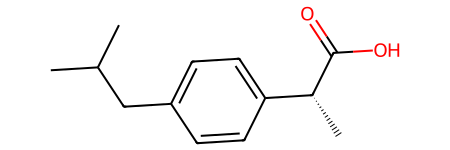

In [24]:
ibuprofen = Chem.MolFromSmiles('CC(C)Cc1ccc(cc1)[C@@H](C)C(=O)O')
ibuprofen

In [25]:
mfp1gen = rdFingerprintGenerator.GetMorganGenerator(radius=1)

ao = rdFingerprintGenerator.AdditionalOutput()
# we have to ask for the information we're interested in by allocating space for it:
ao.AllocateAtomCounts()
ao.AllocateAtomToBits()
ao.AllocateBitInfoMap()

fp = mfp1gen.GetFingerprint(ibuprofen,additionalOutput=ao)

The mapping of bit numbers to central atom and radius:

In [26]:
ao.GetBitInfoMap()

{1: ((1, 0), (10, 0)),
 79: ((3, 1),),
 80: ((3, 0),),
 283: ((0, 1), (2, 1), (11, 1)),
 389: ((14, 1),),
 650: ((13, 0),),
 807: ((12, 0), (14, 0)),
 900: ((10, 1),),
 1057: ((0, 0), (2, 0), (11, 0)),
 1365: ((7, 1),),
 1380: ((4, 0), (7, 0)),
 1750: ((5, 1), (6, 1), (8, 1), (9, 1)),
 1754: ((4, 1),),
 1844: ((12, 1),),
 1847: ((1, 1),),
 1873: ((5, 0), (6, 0), (8, 0), (9, 0)),
 1917: ((13, 1),)}

The number of bits each atom sets:

In [28]:
ao.GetAtomCounts()

(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)

That's a tuple N atoms long with the number of bits each atoms sets

Which bits each atom sets:

In [30]:
ao.GetAtomToBits()

((1057, 283),
 (1, 1847),
 (1057, 283),
 (80, 79),
 (1380, 1754),
 (1873, 1750),
 (1873, 1750),
 (1380, 1365),
 (1873, 1750),
 (1873, 1750),
 (1, 900),
 (1057, 283),
 (807, 1844),
 (650, 1917),
 (807, 389))

That's a tuple N atoms long with a tuple of bit indices for each atom.

As mentioned above, different information may be available for different fingerprints.

Every generator can provide the atom counts and atom to bits list.

The topological torsion and RDKit FP generators, which work with paths (or subgraphs) do not provide a bit info map, but instead offer the paths involved in each bit. In the case of the topological torsion fingeprint these paths use atom indices, while for the RDKit fingerprint they use bond indices.

In [33]:
# disable count simulation because there was a bug with the additional output and count
# simulation which wasn't fixed until the 2022.09.4 release:
ttgen = rdFingerprintGenerator.GetTopologicalTorsionGenerator(countSimulation=False)
ao = rdFingerprintGenerator.AdditionalOutput()
# we have to ask for the information we're interested in by allocating space for it:
ao.AllocateBitPaths()
ao.AllocateAtomCounts()
ao.AllocateAtomToBits()

fp = ttgen.GetFingerprint(ibuprofen,additionalOutput=ao)
ao.GetBitPaths()

{95: ((5, 4, 9, 8), (5, 6, 7, 8), (6, 5, 4, 9), (6, 7, 8, 9)),
 163: ((7, 10, 12, 13),),
 169: ((0, 1, 3, 4), (2, 1, 3, 4)),
 171: ((7, 10, 12, 14),),
 620: ((6, 7, 10, 11), (8, 7, 10, 11)),
 941: ((11, 10, 12, 13),),
 949: ((11, 10, 12, 14),),
 1172: ((5, 6, 7, 10), (9, 8, 7, 10)),
 1353: ((3, 4, 5, 6), (3, 4, 9, 8)),
 1905: ((1, 3, 4, 5), (1, 3, 4, 9)),
 1975: ((6, 7, 10, 12), (8, 7, 10, 12)),
 2009: ((4, 5, 6, 7), (4, 9, 8, 7))}

In [36]:
ms[0].GetNumBonds(),ms[0].GetNumAtoms()

(40, 37)

In [39]:
m = Chem.MolFromSmiles('CCCC')
fp = ttgen.GetFingerprint(m,additionalOutput=ao)
ao.GetBitPaths()

{15: ((0, 1, 2, 3),)}

In [40]:
rdkgen = rdFingerprintGenerator.GetRDKitFPGenerator()
fp = rdkgen.GetFingerprint(m,additionalOutput=ao)
ao.GetBitPaths()

{875: ((0, 1, 2),), 1308: ((0,), (1,), (2,)), 1813: ((0, 1), (1, 2))}